In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

In [2]:
df_aaindex = pd.read_csv('data/aaindex/df_aaindex19.csv')
print(df_aaindex.shape)
df_aaindex.head(1)
tmp = df_aaindex.drop('Unnamed: 0',axis=1).T
aa2val = dict()
for aa, val in zip(tmp.index, tmp.values):
    aa2val[aa]=val

(19, 21)


In [3]:
df_detect_peptide_train = pd.read_csv('data/df_detect_peptide_train.csv')
test = pd.read_csv('data/df_detect_peptide_test.csv')
train, val = train_test_split(df_detect_peptide_train, test_size=0.2, random_state=7)

In [4]:
train.head(1)

,peptide,En,Ec,E1,E2,protein,PEP,ID
595411,K.QELNEPPKQSTSFLVLQEILESEEKGDPNK.P,VYKMLQEKQELNEPP,EEKGDPNKPSGFRSV,QELNEPPKQSTSFLV,EILESEEKGDPNKPS,sp|O00151|PDLI1_HUMAN,QELNEPPKQSTSFLVLQEILESEEKGDPNK,0


In [5]:
def get_data_labelEnc(df):
    label_enc = {v:k+1 for k, v in enumerate('ARNDCQEGHILKMFPSTWYV')}
    label_enc['Z']=0
    aa_data = [np.array([seq.count(a) for a in 'ARNDCQEGHILKMFPSTWYV'] + list(np.array([aa2val[aa] for aa in seq]).sum(axis=0)))
               for seq in df.PEP.values]
    pep_data = [[label_enc[aa] for aa in seq] + [0]*(30-len(seq))
               for seq in df.PEP.values]
    en_data = [[label_enc[aa] for aa in seq]
               for seq in df.En.values]
    ec_data = [[label_enc[aa] for aa in seq]
               for seq in df.Ec.values]
    e1_data = [[label_enc[aa] for aa in seq]
               if seq != '-' else [0 for _ in range(15)]
               for seq in df.E1.values]
    e2_data = [[label_enc[aa] for aa in seq]
               if seq != '-' else [0 for _ in range(15)]
               for seq in df.E2.values]
    return np.array(aa_data), np.array(pep_data), np.array(en_data), np.array(ec_data), np.array(e1_data), np.array(e2_data), np.array(df.ID.values)

In [6]:
aa_train, pep_train, en_train, ec_train, e1_train, e2_train, y_train = get_data_labelEnc(train)
aa_val, pep_val, en_val, ec_val, e1_val, e2_val, y_val = get_data_labelEnc(val)
aa_test, pep_test, en_test, ec_test, e1_test, e2_test, y_test = get_data_labelEnc(test)
print(aa_train.shape, pep_train.shape, en_train.shape, ec_train.shape, e1_train.shape, e2_train.shape, y_train.shape)
print(aa_val.shape, pep_val.shape, en_val.shape, ec_val.shape, e1_val.shape, e2_val.shape, y_val.shape)
print(aa_test.shape, pep_test.shape, en_test.shape, ec_test.shape, e1_test.shape, e2_test.shape, y_test.shape)

(543516, 39) (543516, 30) (543516, 15) (543516, 15) (543516, 15) (543516, 15) (543516,)
(135880, 39) (135880, 30) (135880, 15) (135880, 15) (135880, 15) (135880, 15) (135880,)
(133992, 39) (133992, 30) (133992, 15) (133992, 15) (133992, 15) (133992, 15) (133992,)


In [9]:
train.PEP.values[:4]

array(['QELNEPPKQSTSFLVLQEILESEEKGDPNK', 'LEDQEQR',
       'VANTSTQTMGPRPAAAAAAATPAVR', 'QGHELAK'], dtype=object)

In [10]:
train.En.values[:4]

array(['VYKMLQEKQELNEPP', 'RARMHIQKLEDQEQR', 'PRVMSTQRVANTSTQ',
       'TQPHCSPRQGHELAK'], dtype=object)

In [11]:
print(train.shape[0]+val.shape[0]+test.shape[0])

813388


# Train

In [7]:
from tensorflow.python.client import device_lib

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*2)])
    except RuntimeError as e:
        print(e)

In [8]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.show()

# high param

In [9]:
from tensorflow.keras import layers
from tensorflow import keras

In [11]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim, mask_zero=True)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim, mask_zero=True)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [12]:
vocab_size = 21  # 20 Amino acid + zero padding
maxlen_pep = 30
maxlen_ts = 15

pep_embed_dim = 64  # Embedding size for each token
pep_num_heads = 4  # Number of attention heads
pep_ff_dim = 32  # Hidden layer size in feed forward network inside transformer

ts_embed_dim = 32  # Embedding size for each token
ts_num_heads = 2  # Number of attention heads
ts_ff_dim = 16  # Hidden layer size in feed forward network inside transformer

In [13]:
embedding_layer_pep = TokenAndPositionEmbedding(maxlen_pep, vocab_size, pep_embed_dim)
transformer_block_pep = TransformerBlock(pep_embed_dim, pep_num_heads, pep_ff_dim)
embedding_layer_ts = TokenAndPositionEmbedding(maxlen_ts, vocab_size, ts_embed_dim)
transformer_block_ts = TransformerBlock(ts_embed_dim, ts_num_heads, ts_ff_dim)

# peptide embedding
pep_input = layers.Input(shape=(maxlen_pep,), name='pep_input')
pep_embed = embedding_layer_pep(pep_input)
pep_embed = transformer_block_pep(pep_embed)

# peptide info
meta_input = tf.keras.layers.Input(shape=((39,)))  

# cleavage site embedding
n_input = layers.Input(shape=(maxlen_ts,), name='n_input')
n_embed = embedding_layer_ts(n_input)
n_embed = transformer_block_ts(n_embed)

c_input = layers.Input(shape=(maxlen_ts,), name='c_input')
c_embed = embedding_layer_ts(c_input)
c_embed = transformer_block_ts(c_embed)

m1_input = layers.Input(shape=(maxlen_ts,), name='m1_input')
m1_embed = embedding_layer_ts(m1_input)
m1_embed = transformer_block_ts(m1_embed)

m2_input = layers.Input(shape=(maxlen_ts,), name='m2_input')
m2_embed = embedding_layer_ts(m2_input)
m2_embed = transformer_block_ts(m2_embed)

# peptide LSTM
p_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16), name='pep_lstm')
pep_lstm = p_lstm(pep_embed)
pep_lstm = tf.keras.layers.Dense(32, activation='relu', name='pep_dense')(pep_lstm)
pep_lstm = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(pep_lstm)

# meta info
meta = tf.keras.layers.Dense(32, activation='relu', name='meta_dense')(meta_input)
meta = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(meta)

# cleavage site LSTM
ts_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16), name='ts_lstm')
ts_flat = tf.keras.layers.Dense(16, activation='relu', name='ts_flat')
ts_drop = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))

n_lstm = ts_lstm(n_embed)
n_lstm = ts_flat(n_lstm)
n_lstm = ts_drop(n_lstm)

c_lstm = ts_lstm(c_embed)
c_lstm = ts_flat(c_lstm)
c_lstm = ts_drop(c_lstm)

m1_lstm = ts_lstm(m1_embed)
m1_lstm = ts_flat(m1_lstm)
m1_lstm = ts_drop(m1_lstm)

m2_lstm = ts_lstm(m2_embed)
m2_lstm = ts_flat(m2_lstm)
m2_lstm = ts_drop(m2_lstm)

# Digestibility 
output_array = [] 
metrics_array = {}
loss_array = {}
digestibility_flat = tf.keras.layers.Dense(1, activation='sigmoid', name="digestibility_output")

for i, dense_layer in enumerate([n_lstm, c_lstm, m1_lstm, m2_lstm]):
    layer = tf.keras.layers.concatenate([pep_lstm, dense_layer])
    # A Dense Layer is created for each output
    digestibility_output = digestibility_flat(layer)
    output_array.append(digestibility_output)
    if i ==0:
        metrics_array["digestibility_output"] = 'binary_accuracy'
        loss_array["digestibility_output"] = 'binary_crossentropy'
    else:
        metrics_array["digestibility_output_"+str(i)] = 'binary_accuracy'
        loss_array["digestibility_output_"+str(i)] = 'binary_crossentropy'

# Detectability
detectability_output = tf.keras.layers.concatenate([pep_lstm, 
                                                     meta,
                                                     n_lstm,
                                                     c_lstm,
                                                     m1_lstm,
                                                     m2_lstm])

detectability_output = tf.keras.layers.Dense(64, activation='relu', name='detect_out1')(detectability_output)
detectability_output = tf.keras.layers.Dropout(np.random.uniform(0, 0.2), name='detect_drop1')(detectability_output)
detectability_output = tf.keras.layers.Dense(32, activation='relu', name='detect_out2')(detectability_output)
detectability_output = tf.keras.layers.Dropout(np.random.uniform(0, 0.2), name='detect_drop2')(detectability_output)
detectability_output = tf.keras.layers.Dense(1, activation = 'sigmoid', name='detectability_output')(detectability_output)

output_array.append(detectability_output)

metrics_array['detectability_output'] = 'binary_accuracy'
loss_array['detectability_output'] = 'binary_crossentropy'

In [14]:
model_high = tf.keras.Model(inputs=[pep_input, meta_input, n_input, c_input, m1_input, m2_input],
                            outputs=output_array)
model_high.summary()

model_high.compile(loss=loss_array,
                   optimizer=tf.keras.optimizers.Adam(1e-3),
                   metrics=metrics_array)

es = tf.keras.callbacks.EarlyStopping(monitor='detectability_output_loss',
                                      mode='min', 
                                      verbose=1,
                                      patience=50)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
pep_input (InputLayer)          [(None, 30)]         0                                            
__________________________________________________________________________________________________
n_input (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
c_input (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
m1_input (InputLayer)           [(None, 15)]         0                                            
______________________________________________________________________________________________

In [15]:
history = model_high.fit(
            [pep_train, aa_train, en_train, ec_train, e1_train, e2_train],
            [np.array([1]*len(y_train)), np.array([1]*len(y_train)), np.array([0]*len(y_train)), np.array([0]*len(y_train)), y_train], 
       
            epochs=200,
            batch_size=256,
            validation_data=(
            [pep_val, aa_val, en_val, ec_val, e1_val, e2_val],
            [np.array([1]*len(y_val)), np.array([1]*len(y_val)), np.array([0]*len(y_val)), np.array([0]*len(y_val)), y_val]),
            callbacks=[es]
)

Epoch 1/200
2124/2124 [==============================] - 160s 67ms/step - loss: 3.1163 - digestibility_output_loss: 0.4012 - digestibility_output_1_loss: 0.3996 - digestibility_output_2_loss: 0.6741 - digestibility_output_3_loss: 0.2671 - detectability_output_loss: 1.3744 - digestibility_output_binary_accuracy: 0.8572 - digestibility_output_1_binary_accuracy: 0.8588 - digestibility_output_2_binary_accuracy: 0.4363 - digestibility_output_3_binary_accuracy: 0.8095 - detectability_output_binary_accuracy: 0.6490 - val_loss: 2.1053 - val_digestibility_output_loss: 0.3795 - val_digestibility_output_1_loss: 0.3790 - val_digestibility_output_2_loss: 0.6338 - val_digestibility_output_3_loss: 0.2264 - val_detectability_output_loss: 0.4867 - val_digestibility_output_binary_accuracy: 0.8236 - val_digestibility_output_1_binary_accuracy: 0.8220 - val_digestibility_output_2_binary_accuracy: 0.4880 - val_digestibility_output_3_binary_accuracy: 0.8698 - val_detectability_output_binary_accuracy: 0.7718


2124/2124 [==============================] - 115s 54ms/step - loss: 1.9975 - digestibility_output_loss: 0.3781 - digestibility_output_1_loss: 0.3785 - digestibility_output_2_loss: 0.6240 - digestibility_output_3_loss: 0.2262 - detectability_output_loss: 0.3907 - digestibility_output_binary_accuracy: 0.8296 - digestibility_output_1_binary_accuracy: 0.8268 - digestibility_output_2_binary_accuracy: 0.4957 - digestibility_output_3_binary_accuracy: 0.8615 - detectability_output_binary_accuracy: 0.8252 - val_loss: 1.9965 - val_digestibility_output_loss: 0.3783 - val_digestibility_output_1_loss: 0.3801 - val_digestibility_output_2_loss: 0.6218 - val_digestibility_output_3_loss: 0.2250 - val_detectability_output_loss: 0.3913 - val_digestibility_output_binary_accuracy: 0.8313 - val_digestibility_output_1_binary_accuracy: 0.8240 - val_digestibility_output_2_binary_accuracy: 0.4947 - val_digestibility_output_3_binary_accuracy: 0.8631 - val_detectability_output_binary_accuracy: 0.8244
Epoch 18/200

2124/2124 [==============================] - 111s 52ms/step - loss: 1.9815 - digestibility_output_loss: 0.3775 - digestibility_output_1_loss: 0.3777 - digestibility_output_2_loss: 0.6220 - digestibility_output_3_loss: 0.2258 - detectability_output_loss: 0.3786 - digestibility_output_binary_accuracy: 0.8286 - digestibility_output_1_binary_accuracy: 0.8263 - digestibility_output_2_binary_accuracy: 0.4977 - digestibility_output_3_binary_accuracy: 0.8628 - detectability_output_binary_accuracy: 0.8311 - val_loss: 1.9839 - val_digestibility_output_loss: 0.3799 - val_digestibility_output_1_loss: 0.3815 - val_digestibility_output_2_loss: 0.6190 - val_digestibility_output_3_loss: 0.2235 - val_detectability_output_loss: 0.3800 - val_digestibility_output_binary_accuracy: 0.8196 - val_digestibility_output_1_binary_accuracy: 0.8124 - val_digestibility_output_2_binary_accuracy: 0.5090 - val_digestibility_output_3_binary_accuracy: 0.8737 - val_detectability_output_binary_accuracy: 0.8306
Epoch 34/200

2124/2124 [==============================] - 132s 62ms/step - loss: 1.9697 - digestibility_output_loss: 0.3778 - digestibility_output_1_loss: 0.3776 - digestibility_output_2_loss: 0.6226 - digestibility_output_3_loss: 0.2253 - detectability_output_loss: 0.3663 - digestibility_output_binary_accuracy: 0.8288 - digestibility_output_1_binary_accuracy: 0.8272 - digestibility_output_2_binary_accuracy: 0.4959 - digestibility_output_3_binary_accuracy: 0.8617 - detectability_output_binary_accuracy: 0.8379 - val_loss: 1.9765 - val_digestibility_output_loss: 0.3779 - val_digestibility_output_1_loss: 0.3787 - val_digestibility_output_2_loss: 0.6228 - val_digestibility_output_3_loss: 0.2245 - val_detectability_output_loss: 0.3725 - val_digestibility_output_binary_accuracy: 0.8174 - val_digestibility_output_1_binary_accuracy: 0.8175 - val_digestibility_output_2_binary_accuracy: 0.5044 - val_digestibility_output_3_binary_accuracy: 0.8743 - val_detectability_output_binary_accuracy: 0.8355
Epoch 50/200

2124/2124 [==============================] - 135s 64ms/step - loss: 1.9598 - digestibility_output_loss: 0.3774 - digestibility_output_1_loss: 0.3773 - digestibility_output_2_loss: 0.6207 - digestibility_output_3_loss: 0.2258 - detectability_output_loss: 0.3587 - digestibility_output_binary_accuracy: 0.8284 - digestibility_output_1_binary_accuracy: 0.8276 - digestibility_output_2_binary_accuracy: 0.4973 - digestibility_output_3_binary_accuracy: 0.8615 - detectability_output_binary_accuracy: 0.8423 - val_loss: 1.9759 - val_digestibility_output_loss: 0.3771 - val_digestibility_output_1_loss: 0.3786 - val_digestibility_output_2_loss: 0.6236 - val_digestibility_output_3_loss: 0.2246 - val_detectability_output_loss: 0.3719 - val_digestibility_output_binary_accuracy: 0.8214 - val_digestibility_output_1_binary_accuracy: 0.8178 - val_digestibility_output_2_binary_accuracy: 0.5016 - val_digestibility_output_3_binary_accuracy: 0.8699 - val_detectability_output_binary_accuracy: 0.8351
Epoch 66/200

2124/2124 [==============================] - 139s 66ms/step - loss: 1.9566 - digestibility_output_loss: 0.3766 - digestibility_output_1_loss: 0.3771 - digestibility_output_2_loss: 0.6210 - digestibility_output_3_loss: 0.2253 - detectability_output_loss: 0.3565 - digestibility_output_binary_accuracy: 0.8296 - digestibility_output_1_binary_accuracy: 0.8281 - digestibility_output_2_binary_accuracy: 0.4969 - digestibility_output_3_binary_accuracy: 0.8603 - detectability_output_binary_accuracy: 0.8436 - val_loss: 1.9754 - val_digestibility_output_loss: 0.3792 - val_digestibility_output_1_loss: 0.3792 - val_digestibility_output_2_loss: 0.6214 - val_digestibility_output_3_loss: 0.2245 - val_detectability_output_loss: 0.3711 - val_digestibility_output_binary_accuracy: 0.8222 - val_digestibility_output_1_binary_accuracy: 0.8194 - val_digestibility_output_2_binary_accuracy: 0.5024 - val_digestibility_output_3_binary_accuracy: 0.8690 - val_detectability_output_binary_accuracy: 0.8353
Epoch 82/200

2124/2124 [==============================] - 134s 63ms/step - loss: 1.9527 - digestibility_output_loss: 0.3776 - digestibility_output_1_loss: 0.3776 - digestibility_output_2_loss: 0.6222 - digestibility_output_3_loss: 0.2254 - detectability_output_loss: 0.3500 - digestibility_output_binary_accuracy: 0.8299 - digestibility_output_1_binary_accuracy: 0.8277 - digestibility_output_2_binary_accuracy: 0.4953 - digestibility_output_3_binary_accuracy: 0.8605 - detectability_output_binary_accuracy: 0.8463 - val_loss: 1.9772 - val_digestibility_output_loss: 0.3776 - val_digestibility_output_1_loss: 0.3785 - val_digestibility_output_2_loss: 0.6235 - val_digestibility_output_3_loss: 0.2254 - val_detectability_output_loss: 0.3722 - val_digestibility_output_binary_accuracy: 0.8283 - val_digestibility_output_1_binary_accuracy: 0.8244 - val_digestibility_output_2_binary_accuracy: 0.4970 - val_digestibility_output_3_binary_accuracy: 0.8618 - val_detectability_output_binary_accuracy: 0.8342
Epoch 98/200

2124/2124 [==============================] - 143s 67ms/step - loss: 1.9503 - digestibility_output_loss: 0.3775 - digestibility_output_1_loss: 0.3774 - digestibility_output_2_loss: 0.6227 - digestibility_output_3_loss: 0.2250 - detectability_output_loss: 0.3477 - digestibility_output_binary_accuracy: 0.8283 - digestibility_output_1_binary_accuracy: 0.8284 - digestibility_output_2_binary_accuracy: 0.4966 - digestibility_output_3_binary_accuracy: 0.8616 - detectability_output_binary_accuracy: 0.8482 - val_loss: 1.9750 - val_digestibility_output_loss: 0.3754 - val_digestibility_output_1_loss: 0.3765 - val_digestibility_output_2_loss: 0.6253 - val_digestibility_output_3_loss: 0.2271 - val_detectability_output_loss: 0.3707 - val_digestibility_output_binary_accuracy: 0.8327 - val_digestibility_output_1_binary_accuracy: 0.8283 - val_digestibility_output_2_binary_accuracy: 0.4913 - val_digestibility_output_3_binary_accuracy: 0.8577 - val_detectability_output_binary_accuracy: 0.8367
Epoch 114/20

2124/2124 [==============================] - 108s 51ms/step - loss: 1.9474 - digestibility_output_loss: 0.3772 - digestibility_output_1_loss: 0.3772 - digestibility_output_2_loss: 0.6210 - digestibility_output_3_loss: 0.2256 - detectability_output_loss: 0.3463 - digestibility_output_binary_accuracy: 0.8290 - digestibility_output_1_binary_accuracy: 0.8292 - digestibility_output_2_binary_accuracy: 0.4960 - digestibility_output_3_binary_accuracy: 0.8597 - detectability_output_binary_accuracy: 0.8488 - val_loss: 1.9787 - val_digestibility_output_loss: 0.3758 - val_digestibility_output_1_loss: 0.3774 - val_digestibility_output_2_loss: 0.6258 - val_digestibility_output_3_loss: 0.2258 - val_detectability_output_loss: 0.3738 - val_digestibility_output_binary_accuracy: 0.8304 - val_digestibility_output_1_binary_accuracy: 0.8271 - val_digestibility_output_2_binary_accuracy: 0.4908 - val_digestibility_output_3_binary_accuracy: 0.8602 - val_detectability_output_binary_accuracy: 0.8338
Epoch 130/20

2124/2124 [==============================] - 202s 95ms/step - loss: 1.9450 - digestibility_output_loss: 0.3776 - digestibility_output_1_loss: 0.3775 - digestibility_output_2_loss: 0.6216 - digestibility_output_3_loss: 0.2253 - detectability_output_loss: 0.3430 - digestibility_output_binary_accuracy: 0.8282 - digestibility_output_1_binary_accuracy: 0.8274 - digestibility_output_2_binary_accuracy: 0.4961 - digestibility_output_3_binary_accuracy: 0.8616 - detectability_output_binary_accuracy: 0.8499 - val_loss: 1.9759 - val_digestibility_output_loss: 0.3726 - val_digestibility_output_1_loss: 0.3734 - val_digestibility_output_2_loss: 0.6295 - val_digestibility_output_3_loss: 0.2292 - val_detectability_output_loss: 0.3712 - val_digestibility_output_binary_accuracy: 0.8329 - val_digestibility_output_1_binary_accuracy: 0.8293 - val_digestibility_output_2_binary_accuracy: 0.4889 - val_digestibility_output_3_binary_accuracy: 0.8575 - val_detectability_output_binary_accuracy: 0.8359
Epoch 146/20

2124/2124 [==============================] - 188s 89ms/step - loss: 1.9451 - digestibility_output_loss: 0.3779 - digestibility_output_1_loss: 0.3771 - digestibility_output_2_loss: 0.6223 - digestibility_output_3_loss: 0.2255 - detectability_output_loss: 0.3422 - digestibility_output_binary_accuracy: 0.8290 - digestibility_output_1_binary_accuracy: 0.8290 - digestibility_output_2_binary_accuracy: 0.4958 - digestibility_output_3_binary_accuracy: 0.8594 - detectability_output_binary_accuracy: 0.8502 - val_loss: 1.9785 - val_digestibility_output_loss: 0.3772 - val_digestibility_output_1_loss: 0.3775 - val_digestibility_output_2_loss: 0.6254 - val_digestibility_output_3_loss: 0.2248 - val_detectability_output_loss: 0.3736 - val_digestibility_output_binary_accuracy: 0.8295 - val_digestibility_output_1_binary_accuracy: 0.8267 - val_digestibility_output_2_binary_accuracy: 0.4957 - val_digestibility_output_3_binary_accuracy: 0.8596 - val_detectability_output_binary_accuracy: 0.8346
Epoch 162/20

2124/2124 [==============================] - 151s 71ms/step - loss: 1.9409 - digestibility_output_loss: 0.3770 - digestibility_output_1_loss: 0.3769 - digestibility_output_2_loss: 0.6216 - digestibility_output_3_loss: 0.2253 - detectability_output_loss: 0.3401 - digestibility_output_binary_accuracy: 0.8303 - digestibility_output_1_binary_accuracy: 0.8294 - digestibility_output_2_binary_accuracy: 0.4960 - digestibility_output_3_binary_accuracy: 0.8595 - detectability_output_binary_accuracy: 0.8509 - val_loss: 1.9797 - val_digestibility_output_loss: 0.3805 - val_digestibility_output_1_loss: 0.3818 - val_digestibility_output_2_loss: 0.6192 - val_digestibility_output_3_loss: 0.2236 - val_detectability_output_loss: 0.3747 - val_digestibility_output_binary_accuracy: 0.8233 - val_digestibility_output_1_binary_accuracy: 0.8190 - val_digestibility_output_2_binary_accuracy: 0.5024 - val_digestibility_output_3_binary_accuracy: 0.8672 - val_detectability_output_binary_accuracy: 0.8330
Epoch 178/20

2124/2124 [==============================] - 149s 70ms/step - loss: 1.9400 - digestibility_output_loss: 0.3771 - digestibility_output_1_loss: 0.3769 - digestibility_output_2_loss: 0.6219 - digestibility_output_3_loss: 0.2247 - detectability_output_loss: 0.3393 - digestibility_output_binary_accuracy: 0.8296 - digestibility_output_1_binary_accuracy: 0.8282 - digestibility_output_2_binary_accuracy: 0.4966 - digestibility_output_3_binary_accuracy: 0.8618 - detectability_output_binary_accuracy: 0.8516 - val_loss: 1.9801 - val_digestibility_output_loss: 0.3727 - val_digestibility_output_1_loss: 0.3735 - val_digestibility_output_2_loss: 0.6295 - val_digestibility_output_3_loss: 0.2291 - val_detectability_output_loss: 0.3754 - val_digestibility_output_binary_accuracy: 0.8387 - val_digestibility_output_1_binary_accuracy: 0.8344 - val_digestibility_output_2_binary_accuracy: 0.4847 - val_digestibility_output_3_binary_accuracy: 0.8509 - val_detectability_output_binary_accuracy: 0.8333
Epoch 194/20

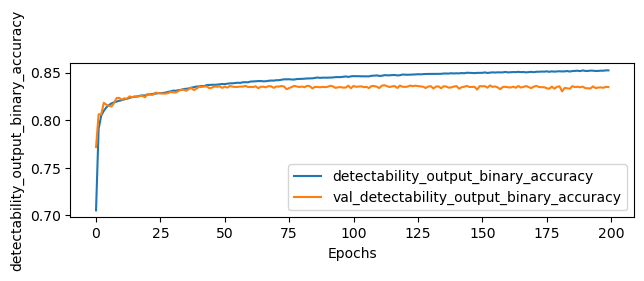

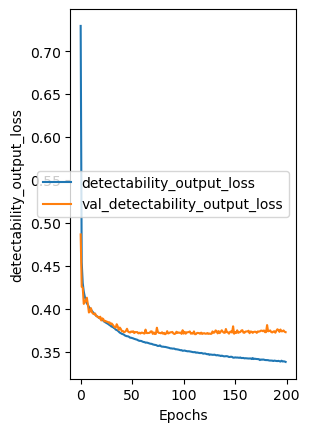

In [16]:
plt.figure(figsize=(16,2))
plt.subplot(1,2,1)

plot_graphs(history, 'detectability_output_binary_accuracy')
plt.subplot(1,2,2)
plot_graphs(history, 'detectability_output_loss')

# eval

In [17]:
test_acc = model_high.evaluate([pep_test, aa_test, en_test, ec_test, e1_test, e2_test], y_test)
# print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc[-1]))

4188/4188 [==============================] - 118s 27ms/step - loss: 45.5405 - digestibility_output_loss: 1.9300 - digestibility_output_1_loss: 1.9361 - digestibility_output_2_loss: 13.9601 - digestibility_output_3_loss: 27.3423 - detectability_output_loss: 0.3719 - digestibility_output_binary_accuracy: 0.6119 - digestibility_output_1_binary_accuracy: 0.6138 - digestibility_output_2_binary_accuracy: 0.3979 - digestibility_output_3_binary_accuracy: 0.4066 - detectability_output_binary_accuracy: 0.8358
Test Accuracy: 0.8357663154602051


In [18]:
yp = model_high.predict([pep_test, aa_test, en_test, ec_test, e1_test, e2_test])

In [19]:
# prediction
y_pred = [1 if i>=0.5 else 0 for i in yp[-1]]

In [20]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.80      0.83     66996
           1       0.82      0.87      0.84     66996

    accuracy                           0.84    133992
   macro avg       0.84      0.84      0.84    133992
weighted avg       0.84      0.84      0.84    133992



rf auc : 0.9151472346347536


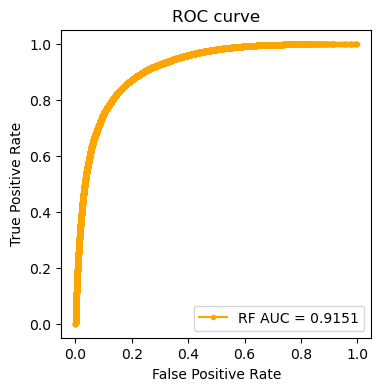

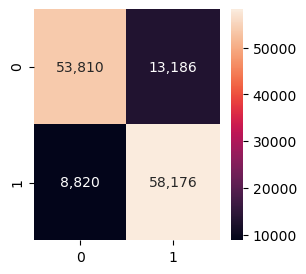

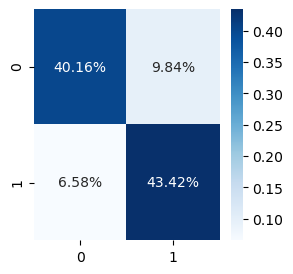

In [21]:
# AUC
probs = yp[-1]
rf_auc = roc_auc_score(y_test, probs)
print('rf auc : {}'.format(rf_auc))
# plot the roc curve for the model_high
rf_fpr, rf_tpr, _ = roc_curve(y_test, probs)
plt.figure(figsize=(4, 4))
plt.plot(rf_fpr, rf_tpr, marker='.', label='RF AUC = {:.4f}'.format(rf_auc), color='orange')
plt.title('ROC curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

cf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()